# Inference and Validation

Now that you have a trained network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that hasn't been seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training.

## Import Resources

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%config InlineBacken.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
print('Using:')
print(f'\t\u2022 TensorFlow version: {tf.__version__}')
print(f'\t\u2022 tf.keras version: {tf.keras.__version__}')
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.1.0
	• tf.keras version: 2.2.4-tf
	• GPU device not found. Running on CPU


## Load the Dataset

We are now going to load the Fashion-MNIST dataset using tensorflow_datasets as we've done before. In this case, however, we are going to define how to split the dataset ourselves. We are going to split the dataset such that 60\% of the data will be used for training, 20\% of the data will be used for validation, and the remaining 20\% of the data will be used for testing. 

To do this, we are going to do two things in succession. First we are going to combine (merge) the `train` and `test` splits. After the splits are merged into a single set, we are going to sub-split it into three sets, where the first set has 60\% of the data, the second set has 20\% of the data, and the third set has the remaining 20\% of the data. 

To merge all the splits of a dataset together, we can use `split=tfds.Split.ALL`. For example,

```python
dataset = tfds.load('fashion_mnist', split=tfds.Split.ALL)
```

will return a `dataset` that contains a single set with 70,000 examples. This is because the Fashion-MNIST dataset has a `train` split with 60,000 examples and a `test` split with 10,000 examples. The `tfds.Split.ALL` keyword merged both splits into a single set containing the combined data from both splits. 

After we have merged the splits into a single set, we need to sub-split it. We can sub-split our dataset by using the `.subsplit()` method. There are various ways in which we can use the `.subsplit()` method. Here we are going to sub-split the data by providing the percentage of data we want in each set. To do this we just pass a list with percentages we want in each set. For example,

```python
split=tfds.Split.ALL.subsplit([60,20,20])
```

will sub-split our dataset into three sets, where the first set has 60\% of the data, the second set has 20\% of the data, and the third set has the remaining 20\% of the data. A word of **caution**, TensorFlow Datasets does not guarantee the reproducibility of the sub-split operations. That means, that two different users working on the same version of a dataset and using the same sub-split operations could end-up with two different sets of examples. Also, if a user regenerates the data, the sub-splits may no longer be the same. To learn more about `subsplit` and other ways to sub-split your data visit the [Split Documentation](https://www.tensorflow.org/datasets/splits#subsplit).

In [6]:
train_split = 60
test_val_split = 20

splits = tfds.Split.ALL.subsplit([train_split, test_val_split, test_val_split])

dataset, dataset_info = tfds.load('fashion_mnist', split = splits, 
                                  as_supervised = True, with_info = True)

training_set, validation_set, test_set = dataset

When we use `split=tfds.Split.ALL.subsplit([60,20,20])`, `tensorflow_datasets` returns a tuple with our sub-splits. Since we divided our dataset into 3 sets, then, in this case, `dataset` should be a tuple with 3 elements.

In [7]:
# Check that dataset is a tuple
print(f'dataset has type: {type(dataset)}')

# Print the number of elements in a dataset
print(f'dataset has {len(dataset)} elements')

dataset has type: <class 'tuple'>
dataset has 3 elements


In [8]:
# Display dataset
dataset

(<_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>,
 <_OptionsDataset shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>)

In [9]:
# Display dataset_info
dataset_info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=1.0.0,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    urls=['https://github.com/zalandoresearch/fashion-mnist'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume  

## Explore the Dataset

In [10]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = (total_examples * train_split) // 100
num_validation_examples = (total_examples * test_val_split) // 100
num_test_examples = num_validation_examples

print(f'There are {num_training_examples} in the training set')
print(f'There are {num_validation_examples} in the validation set')
print(f'There are {num_test_examples} in the test set')

There are 42000 in the training set
There are 14000 in the validation set
There are 14000 in the test set


In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

## Create Pipeline

In [12]:
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
validation_batches = validation_set.cache().batch(batch_size).map(normalize).prefetch(1)
testing_batches = test_set.cache().batch(batch_size).map(normalize).prefetch(1)

## Build the Model

In [13]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

In [14]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

## Evaluate Loss and Accuracy on the Test Set

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We'll focus on accuracy here. Let's see how the model performs on our test set.

In [15]:
loss, accuracy = model.evaluate(testing_batches)

print(f'\n\nThe loss for the testing set is: {loss:.3f}')
print(f'The accuracy for the testing set is: {accuracy:.3%}')

    174/Unknown - 1s 934ms/step - loss: 2.3528 - accuracy: 0.046 - 1s 472ms/step - loss: 2.3556 - accuracy: 0.093 - 1s 322ms/step - loss: 2.3485 - accuracy: 0.088 - 1s 259ms/step - loss: 2.3688 - accuracy: 0.070 - 1s 211ms/step - loss: 2.3578 - accuracy: 0.084 - 1s 180ms/step - loss: 2.3624 - accuracy: 0.075 - 1s 165ms/step - loss: 2.3543 - accuracy: 0.078 - 1s 146ms/step - loss: 2.3507 - accuracy: 0.082 - 1s 133ms/step - loss: 2.3518 - accuracy: 0.074 - 1s 122ms/step - loss: 2.3438 - accuracy: 0.071 - 1s 118ms/step - loss: 2.3434 - accuracy: 0.076 - 1s 113ms/step - loss: 2.3475 - accuracy: 0.074 - 1s 106ms/step - loss: 2.3526 - accuracy: 0.074 - 1s 101ms/step - loss: 2.3550 - accuracy: 0.072 - 1s 95ms/step - loss: 2.3532 - accuracy: 0.074 - 1s 90ms/step - loss: 2.3520 - accuracy: 0.07 - 1s 86ms/step - loss: 2.3471 - accuracy: 0.07 - 1s 82ms/step - loss: 2.3486 - accuracy: 0.07 - 2s 80ms/step - loss: 2.3484 - accuracy: 0.06 - 2s 77ms/step - loss: 2.3466 - accuracy: 0.07 - 2s 76ms/step 

## Train the Model with the Validation Set

Now let's train our network as usual, but this time we are also going to incorporate our validation set into the training process. 

During training, the model will only use the training set in order to decide how to modify its weights and biases. Then, after every training epoch we calculate the loss on the training and validation sets. These metrics tell us how well our model is "learning" because it they show how well the model generalizes to data that is not used for training. It's important to remember that the model does not use any part of the validation set to tune its weights and biases, therefore it can tell us if we're overfitting the training set.

We can incorporate our validation set into the training process by including the `validation_data=validation_batches` argument in the `.fit` method.

In [16]:
EPOCHS = 30

history = model.fit(training_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/30
    173/Unknown - 4s 4s/step - loss: 2.3122 - accuracy: 0.04 - 4s 2s/step - loss: 2.2790 - accuracy: 0.17 - 4s 1s/step - loss: 2.2256 - accuracy: 0.19 - 4s 921ms/step - loss: 2.1515 - accuracy: 0.222 - 4s 741ms/step - loss: 2.0977 - accuracy: 0.250 - 4s 626ms/step - loss: 2.0441 - accuracy: 0.307 - 4s 540ms/step - loss: 2.0003 - accuracy: 0.325 - 4s 474ms/step - loss: 1.9503 - accuracy: 0.355 - 4s 424ms/step - loss: 1.9018 - accuracy: 0.376 - 4s 383ms/step - loss: 1.8509 - accuracy: 0.392 - 4s 349ms/step - loss: 1.8074 - accuracy: 0.407 - 4s 321ms/step - loss: 1.7659 - accuracy: 0.425 - 4s 297ms/step - loss: 1.7214 - accuracy: 0.443 - 4s 277ms/step - loss: 1.6693 - accuracy: 0.466 - 4s 260ms/step - loss: 1.6314 - accuracy: 0.478 - 4s 246ms/step - loss: 1.5975 - accuracy: 0.491 - 4s 232ms/step - loss: 1.5604 - accuracy: 0.500 - 4s 220ms/step - loss: 1.5321 - accuracy: 0.512 - 4s 210ms/step - loss: 1.4970 - accuracy: 0.521 - 4s 200ms/step - loss: 1.4663 - accuracy: 0.531 - 4s 

In [17]:
# Check that history.history is a dictionary
print(f'history.history has type {type(history.history)}')

# Print the keys for history.history
print(f'The keys of history.history are {history.history.keys()}')

history.history has type <class 'dict'>
The keys of history.history are dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Let's use the `history.history` dictionary to plot our model's loss and accuracy values obtained during training.

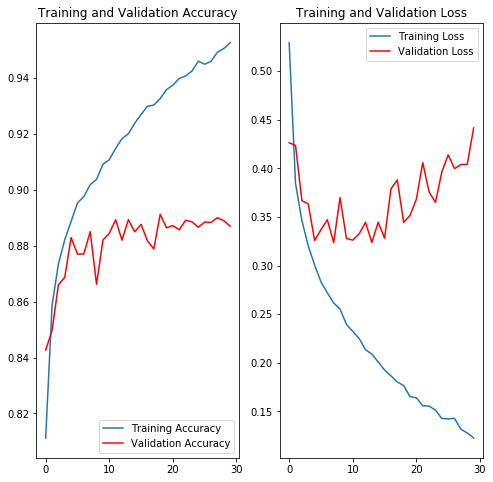

In [18]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize = (8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, color = 'r', label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, color = 'r', label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

## Early Stopping

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 
This happens when our model performs really well on the training data but it fails to generalize well enough to also perform well on the validation set. We can tell that this is happening because when we finished training the validation loss is higher than the training loss.

One way to prevent our model from overfitting is by stopping training when we achieve the lowest validation loss. If we take a look at the plots we can see that at the beginning of training the validation loss starts decreasing, then after some epochs it levels off, and then it just starts increasing. Therefore, we can stop training our model when the validation loss levels off, such that our network is accurate but it's not overfitting.

This strategy is called **early-stopping**. We can implement early stopping in `tf.keras` by using a **callback**. A callback is a set of functions to be applied at given stages of the training process. You can pass a list of callbacks to the `.fit()` method by using the `callbacks` keyword argument. 

To implement early-stopping during training we will use the callback:


```python
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
```

The `monitor` argument specifies the quantity we want to monitor during training to determine when to stop training. The `patience` argument determines the number of consecutive epochs with no significant improvement after which training will be stopped. We can also specify the minimum change in the monitored quantity to qualify as an improvement, by specifying the `min_delta` argument. For more information on the early-stopping callback check out the [EarlyStopping 
documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/callbacks/EarlyStopping#class_earlystopping).

In [19]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)), 
        tf.keras.layers.Dense(256, activation = 'relu'), 
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Stop training when there is no improvemtn in the validation set for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit(training_batches, 
                    epochs = 100,
                    validation_data = validation_batches, 
                    callbacks = [early_stopping])

Epoch 1/100
    174/Unknown - 1s 1s/step - loss: 2.2695 - accuracy: 0.10 - 1s 602ms/step - loss: 2.2010 - accuracy: 0.171 - 1s 406ms/step - loss: 2.1461 - accuracy: 0.239 - 1s 308ms/step - loss: 2.0864 - accuracy: 0.304 - 1s 249ms/step - loss: 2.0521 - accuracy: 0.312 - 1s 209ms/step - loss: 2.0023 - accuracy: 0.325 - 1s 182ms/step - loss: 1.9451 - accuracy: 0.346 - 1s 161ms/step - loss: 1.8976 - accuracy: 0.357 - 1s 145ms/step - loss: 1.8378 - accuracy: 0.366 - 1s 132ms/step - loss: 1.8094 - accuracy: 0.378 - 1s 121ms/step - loss: 1.7630 - accuracy: 0.400 - 1s 112ms/step - loss: 1.7155 - accuracy: 0.411 - 1s 105ms/step - loss: 1.6792 - accuracy: 0.420 - 1s 98ms/step - loss: 1.6399 - accuracy: 0.428 - 1s 93ms/step - loss: 1.6148 - accuracy: 0.43 - 1s 88ms/step - loss: 1.5746 - accuracy: 0.44 - 1s 83ms/step - loss: 1.5359 - accuracy: 0.46 - 1s 79ms/step - loss: 1.5004 - accuracy: 0.48 - 1s 76ms/step - loss: 1.4798 - accuracy: 0.49 - 1s 73ms/step - loss: 1.4610 - accuracy: 0.49 - 1s 70ms

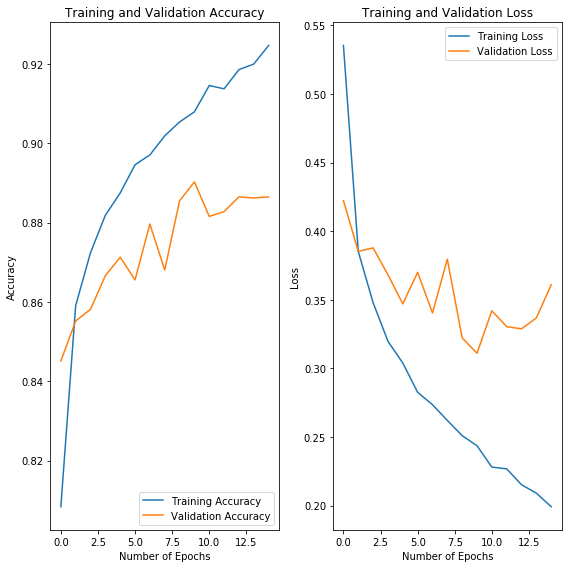

In [20]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize = (8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.tight_layout()

## Dropout

Another common method to reduce overfitting is called **dropout**, where we randomly drop neurons in our model during training. This forces the network to share information between weights, increasing its ability to generalize to new data. We can implement dropout in `tf.keras` by adding `tf.keras.layers.Dropout()` layers to our models. 

```python
tf.keras.layers.Dropout(rate)
```
randomly sets a fraction `rate` of the dropout layer's input units to 0 at each update during training. The `rate` argument is a float between 0 and 1, that determines the fraction of neurons from the previous layer that should be turned off. For example,  `rate =0.5` will drop 50\% of the neurons. 

It's important to note that we should never apply dropout to the input layer of our network. Also, remember that during training we want to use dropout to prevent overfitting, but during inference we want to use all the neurons in the network. `tf.keras` is designed to care of this automatically, so it uses the dropout layers during training, but automatically ignores them during inference.

In [21]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)), 
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

history = model.fit(training_batches,
                    epochs = 100, 
                    validation_data = validation_batches, 
                    callbacks = [early_stopping])

Epoch 1/100
    173/Unknown - 2s 2s/step - loss: 2.4405 - accuracy: 0.07 - 2s 831ms/step - loss: 2.3714 - accuracy: 0.140 - 2s 560ms/step - loss: 2.3265 - accuracy: 0.145 - 2s 425ms/step - loss: 2.2803 - accuracy: 0.164 - 2s 344ms/step - loss: 2.2449 - accuracy: 0.162 - 2s 290ms/step - loss: 2.2238 - accuracy: 0.177 - 2s 251ms/step - loss: 2.1900 - accuracy: 0.198 - 2s 222ms/step - loss: 2.1553 - accuracy: 0.210 - 2s 200ms/step - loss: 2.1249 - accuracy: 0.225 - 2s 182ms/step - loss: 2.1044 - accuracy: 0.234 - 2s 168ms/step - loss: 2.0713 - accuracy: 0.244 - 2s 155ms/step - loss: 2.0499 - accuracy: 0.256 - 2s 146ms/step - loss: 2.0322 - accuracy: 0.259 - 2s 137ms/step - loss: 1.9941 - accuracy: 0.280 - 2s 129ms/step - loss: 1.9709 - accuracy: 0.293 - 2s 122ms/step - loss: 1.9519 - accuracy: 0.300 - 2s 116ms/step - loss: 1.9314 - accuracy: 0.303 - 2s 110ms/step - loss: 1.9072 - accuracy: 0.309 - 2s 105ms/step - loss: 1.8926 - accuracy: 0.313 - 2s 100ms/step - loss: 1.8621 - accuracy: 0.

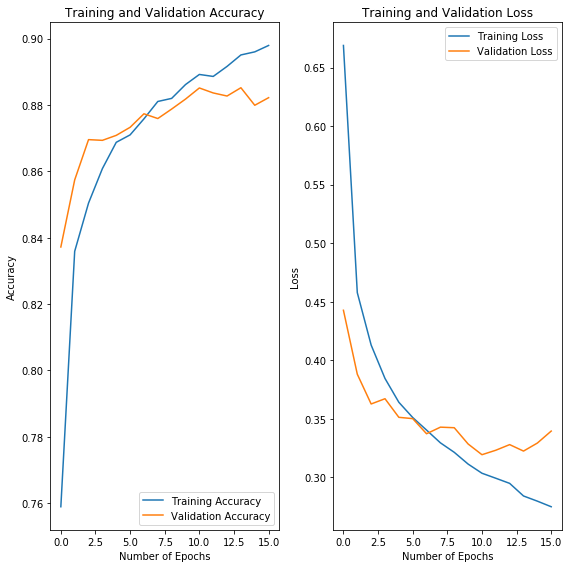

In [22]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range = range(len(training_accuracy))

plt.figure(figsize = (8, 8))
plt.subplot(1,2,1)
plt.plot(epochs_range, training_accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, training_loss, label = 'Training Loss')
plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.tight_layout()

## Inference

Now that the model is trained, we can use it to perform inference. Here we are going to perform inference on 30 images and print the labels in green if our model's prediction matches the true label. On the other hand, if our model's prediction doesn't match the true label, we print the label in red. 

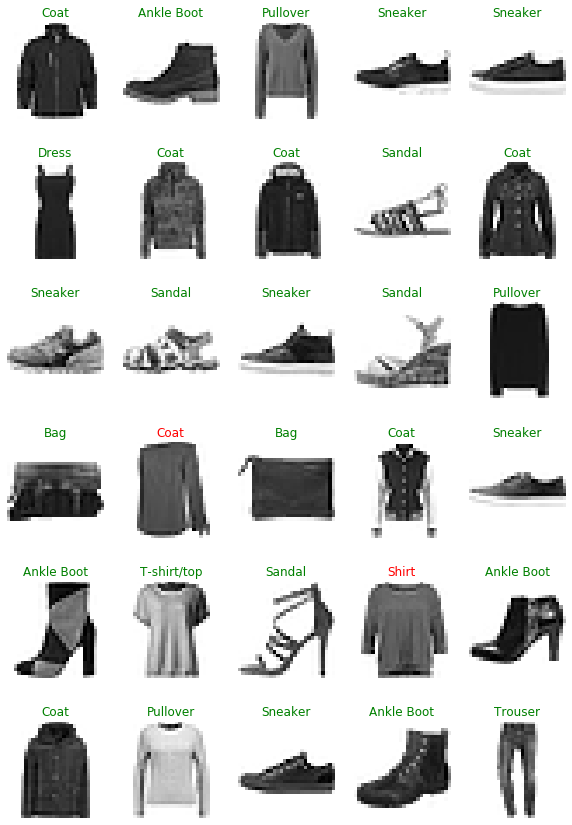

In [23]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()
    
plt.figure(figsize = (10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')